# Bussiness Problem

##### The objective behind this project is to analyse and come up with best possible neighborhood options in the Bangkok to rent a apartment. Use data science and machine learning techniques with python to find neighborhood which has more features which will make living more comfortable and pocket friendly.

In [1]:
#load Librabries
import pandas as pd
import numpy as np
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
from geopy.distance import great_circle
import geocoder
# map rendering library
import folium
# library to handle JSON files
import json 
from pandas.io.json import json_normalize 
# library to handle requests
import requests 
from requests import get
from bs4 import BeautifulSoup
import re
from time import sleep
# Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans

## Collect Data

In [2]:
#1.Scraping local thiland website for apartments data in Bangkok
Apartment_list_available= True
Webpage_number = 1
Apartments=[]

while Apartment_list_available:
    headers = {'User-agent': 'Googlebot'}
    url='https://www.thailand-property.com/properties-for-rent/bangkok?page={}'.format(Webpage_number)
    response=requests.get(url,headers=headers).text
    soup= BeautifulSoup(response ,'html.parser')
    apartment_containers = soup.find_all('div', class_="search-list normal")
    apartment_containers_featured = soup.find_all('div', class_="search-list featured")
    apartment_containers = apartment_containers + apartment_containers_featured
    if len(apartment_containers) == 0:
        break
    
    for apt in apartment_containers:
        try:
            size_elements = apt.find('div', class_="accommodation").find_all("li")
            size=size_elements[-1].text.split()[0]
            if(int(size) < 10):
                size = np.nan
        except:
            size = np.nan

        try:
            rooms = apt.find('div', class_="accommodation").find_all("li")[0].text
            if "m2" in rooms:
                rooms=np.nan
        except:
            rooms = np.nan

        try:
            price = apt.find('div', class_="price").text.split()[1].replace(',','')
        except:
            price = np.nan
                
        try:
            address = apt.find('div', class_="location").text.split(',')[0]
            address=address[2:]
        except:
            address = None 
        #print(str(address)+" "+ str(size)+" "+str(price)+" "+str(rooms))
        Apartments.append([ address, size, rooms, price])
    Webpage_number += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))

## Clean, process and organize data 

In [3]:
#set column names and build a dataframe from previous results
column_names = ['Address', 'Size', 'Rooms', 'Price']
rental_properties = pd.DataFrame(Apartments, columns=column_names)
rental_properties.drop(rental_properties.loc[rental_properties['Price']=="for"].index ,inplace=True)

In [4]:
#Pre-process & Visualize the data
rental_properties['Size'] = rental_properties['Size'].astype('float')
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')
rental_properties['Price'] = rental_properties['Price'].astype('float')
rental_properties['Address'] = rental_properties['Address'].astype('str')
address=[]
for _property in rental_properties['Address']:
    address.append(str(_property).replace("\n","").replace("BTS","").replace("  "," "))
rental_properties['City'] = address
    

In [5]:
#Calculate the price per meter squared
rental_properties['Price/m2'] = (rental_properties['Price']/rental_properties['Size']).round(2)
rental_properties.head()

,Address,Size,Rooms,Price,City,Price/m2
0,Khlong Toei,55.0,2.0,40000.0,Khlong Toei,727.27
1,Khlong Toei,29.0,1.0,17000.0,Khlong Toei,586.21
2,Khlong Toei,48.0,1.0,35000.0,Khlong Toei,729.17
3,Khlong Toei,29.0,1.0,18000.0,Khlong Toei,620.69
4,Watthana,NaN,NaN,195000.0,Watthana,NaN


In [6]:
rental_properties.describe()

,Size,Rooms,Price,Price/m2
count,1009.000000,1148.000000,1.250000e+03,1009.000000
mean,120.480674,1.986934,9.267142e+04,582.272914
std,114.056324,1.123112,1.103092e+06,264.697461
min,22.000000,1.000000,7.500000e+03,68.750000
25%,46.000000,1.000000,2.700000e+04,400.000000
50%,76.000000,2.000000,4.500000e+04,540.540000
75%,150.000000,3.000000,7.200000e+04,725.810000
max,700.000000,16.000000,3.900000e+07,2833.330000


In [7]:
rental_properties.dtypes

Address      object
Size        float64
Rooms       float64
Price       float64
City         object
Price/m2    float64
dtype: object

In [8]:
#Remove rows with NA values in all columns except for the number of rooms since there are too many missing values
rental_properties.dropna(subset=['Address', 'Rooms', 'Size', 'Price'], inplace=True)

In [9]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 996 apartments in the dataset


In [10]:
#Let's check how many apartments per room number we have in our dataset
rental_properties['Rooms'].value_counts()

1.0     386
2.0     341
3.0     183
4.0      64
5.0      14
6.0       4
7.0       3
16.0      1
Name: Rooms, dtype: int64

In [11]:
#Let's remove all rows with rooms larger than 6. Apartments bigger than 6 will most likely be luxurious apartments and does not fit the target group.
rental_properties = rental_properties[rental_properties['Rooms'] <= 6]

C:\Users\dhanashree.nangre\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dhanashree.nangre\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Khlong Toei'),
 Text(1, 0, 'Watthana'),
 Text(2, 0, 'Pathum Wan'),
 Text(3, 0, 'Chatuchak'),
 Text(4, 0, 'Huai Khwang'),
 Text(5, 0, 'Phra Khanong'),
 Text(6, 0, 'Yan Nawa'),
 Text(7, 0, 'Prawet'),
 Text(8, 0, 'Ratchathewi'),
 Text(9, 0, 'Bang Rak'),
 Text(10, 0, 'Sathon'),
 Text(11, 0, 'Khlong San'),
 Text(12, 0, 'Bangkok'),
 Text(13, 0, 'Thon Buri'),
 Text(14, 0, 'Bang Kapi'),
 Text(15, 0, 'Suan Luang'),
 Text(16, 0, 'Taling Chan'),
 Text(17, 0, 'Bang Kho Laem'),
 Text(18, 0, 'Phaya Thai'),
 Text(19, 0, 'Lat Phrao'),
 Text(20, 0, 'Din Daeng'),
 Text(21, 0, 'Bangkok Thong Lo'),
 Text(22, 0, 'Bangkok Nana'),
 Text(23, 0, 'Phasi Charoen'),
 Text(24, 0, 'Chom Thong'),
 Text(25, 0, 'Lat Krabang'),
 Text(26, 0, 'Bang Sue'),
 Text(27, 0, 'Bangkok Ratchadamri'),
 Text(28, 0, 'Bang Na'),
 Text(29, 0, 'Sai Mai'),
 Text(30, 0, 'Bangkok Phrom Phong'),
 Text(31, 0, 'Bangkok Chong Nonsi'),
 Text(32, 0, 'Bang Bon'),
 Text(33, 0, 'Don Mueang'),
 Text(34, 0, 'Bangkok Ekkamai'),
 Text(35,

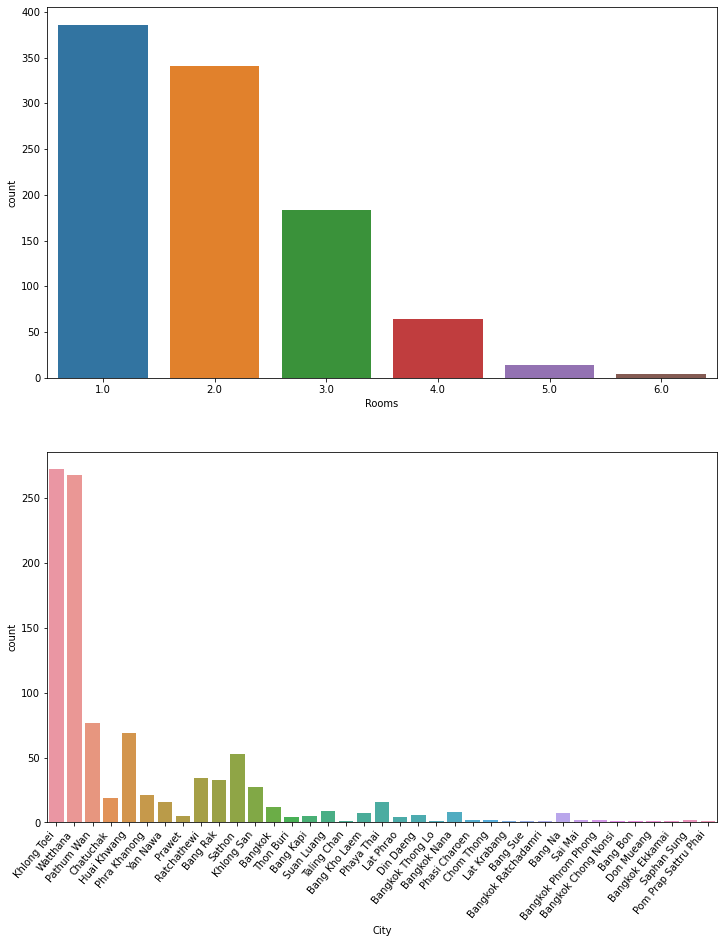

In [12]:
#We can visualize the number of apartments per room number and number of apartments in each city
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['City'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

## Analyze data

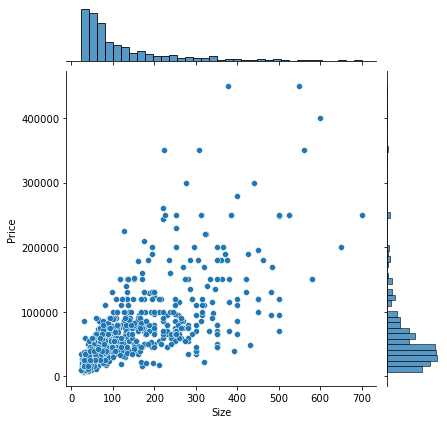

In [13]:
#Plot the price and check for any outliers
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

In [14]:
#Remove the outliers
rental_properties = rental_properties[rental_properties['Price'] <= 200000]

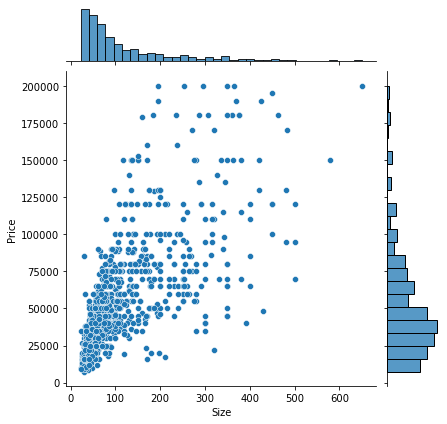

In [15]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

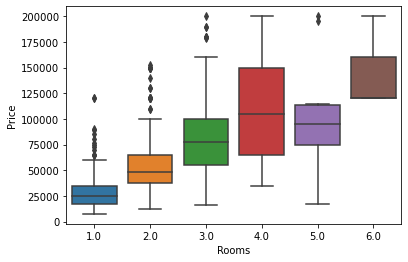

In [16]:
#We expect the value of properties to go up as the number of rooms increases. 
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

<AxesSubplot:xlabel='Rooms', ylabel='Price/m2'>

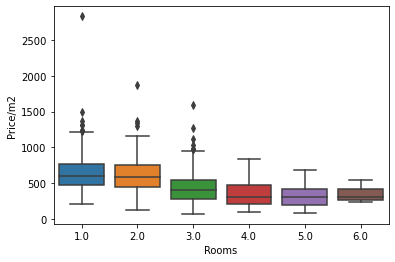

In [17]:
#In the following plot we can see that the price/m2 is in the same price range for all size apartments besides for single room apartments where the price/m2 goes even higher
sns.boxplot(x='Rooms', y='Price/m2', data=rental_properties)

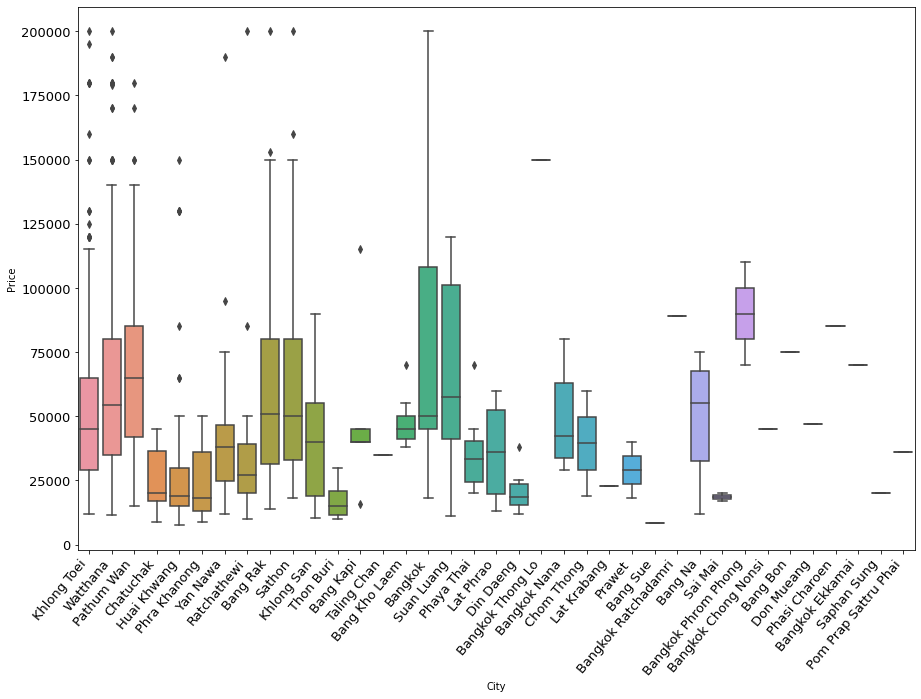

In [18]:
#Let's also check the differences in price per m2 in each district
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='City', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

In [19]:
#get list of neighborhoods
_neighborhoods = rental_properties['City'].drop_duplicates()
_neighborhoods.count()
Bangkok_neighborhoods=[]
for e in _neighborhoods:
    Bangkok_neighborhoods.append(str(e))

In [20]:
#Get coordinates for each neighborhoods
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Bangkok'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
coords = [ get_latlng(neighborhood) for neighborhood in Bangkok_neighborhoods]
neighborhood_coordinates = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
neighborhood_coordinates['Neighborhood'] = Bangkok_neighborhoods
neighborhood_coordinates

,Latitude,Longitude,Neighborhood
0,13.708138,100.583613,Khlong Toei
1,13.729780,100.585360,Watthana
2,13.736610,100.523490,Pathum Wan
3,13.828790,100.559956,Chatuchak
4,13.776606,100.579319,Huai Khwang
5,13.702117,100.601743,Phra Khanong
6,13.696239,100.542272,Yan Nawa
7,13.759119,100.534240,Ratchathewi
8,13.730552,100.523716,Bang Rak
9,13.708123,100.526180,Sathon


In [21]:
Address_bangkok = 'Bangkok'
geolocator = Nominatim(user_agent="my-bangkok")
location = geolocator.geocode(Address_bangkok)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok 13.7544238, 100.4930399.


In [22]:
# can visualize the citier on a map
map_Bangkok = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(neighborhood_coordinates['Latitude'], neighborhood_coordinates['Longitude'], neighborhood_coordinates['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Bangkok)  
    
map_Bangkok

In [23]:
#Calculate the mean per district
mean_per_location = rental_properties.groupby('City').mean().reset_index()
mean_per_location.head()

,City,Size,Rooms,Price,Price/m2
0,Bang Bon,170.000000,3.000000,75000.000000,441.180000
1,Bang Kapi,237.400000,3.600000,51200.000000,227.024000
2,Bang Kho Laem,131.000000,2.571429,47857.142857,421.351429
3,Bang Na,166.428571,3.000000,48857.142857,351.664286
4,Bang Rak,109.375000,1.781250,61062.500000,624.582813


In [24]:
#Define Foursquare Credentials and Version
CLIENT_ID = '0DZQHTS1JPPF0VUH1I2BUBV4ZWGILOEET1IN1BHPJ3KJXNXY' 
CLIENT_SECRET = 'A5B4NJWT5MPURUZE11PG05IFNLASIQ3MB3MAYAO3TBYU3UZ5' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
radius = 500

venues = []

for lat, long, neighborhood in zip(neighborhood_coordinates['Latitude'], neighborhood_coordinates['Longitude'], neighborhood_coordinates['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((  
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))
Bangkok_venues_df = pd.DataFrame(venues)
Bangkok_venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(Bangkok_venues_df.shape)
Bangkok_venues_df.head()

Your credentails:
CLIENT_ID: 0DZQHTS1JPPF0VUH1I2BUBV4ZWGILOEET1IN1BHPJ3KJXNXY
CLIENT_SECRET:A5B4NJWT5MPURUZE11PG05IFNLASIQ3MB3MAYAO3TBYU3UZ5
(1163, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Khlong Toei,13.708138,100.583613,Black Cabin,13.711523,100.586366,Bar
1,Khlong Toei,13.708138,100.583613,Stu-fe' By Monotone,13.711633,100.586379,Recording Studio
2,Khlong Toei,13.708138,100.583613,R&B Karaoke (อาร์แอนด์บี คาราโอเกะ),13.712528,100.583741,Karaoke Bar
3,Khlong Toei,13.708138,100.583613,อาบ-อบ-บาร์,13.710530,100.583598,Bar
4,Khlong Toei,13.708138,100.583613,Khlong Phra Khanong (คลองพระโขนง),13.706874,100.586239,Canal


In [25]:
print('{} venues are collected'.format(Bangkok_venues_df.shape[0]))

1163 venues are collected


In [26]:
Bangkok_venues_df.groupby('Neighborhood').count()


,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Bang Bon,4,4,4,4,4,4
Bang Kapi,24,24,24,24,24,24
Bang Kho Laem,18,18,18,18,18,18
Bang Na,11,11,11,11,11,11
Bang Rak,19,19,19,19,19,19
Bang Sue,14,14,14,14,14,14
Bangkok,37,37,37,37,37,37
Bangkok Chong Nonsi,36,36,36,36,36,36
Bangkok Ekkamai,80,80,80,80,80,80


In [27]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Bangkok_venues_df['VenueCategory'].unique())))

There are 171 uniques categories.


In [28]:
#Analyze Each Neighborhood
Bangkok_onehot = pd.get_dummies(Bangkok_venues_df[['VenueCategory']], prefix="", prefix_sep="")
Bangkok_onehot['Neighborhoods'] = Bangkok_venues_df['Neighborhood'] 
fixed_columns = [Bangkok_onehot.columns[-1]] + list(Bangkok_onehot.columns[:-1])
Bangkok_onehot = Bangkok_onehot[fixed_columns]
print(Bangkok_onehot.shape)
Bangkok_onehot.head()

(1163, 172)


,Neighborhoods,Accessories Store,Airport Service,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,Auto Garage,BBQ Joint,...,Tonkatsu Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant
0,Khlong Toei,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Khlong Toei,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Khlong Toei,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Khlong Toei,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Khlong Toei,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#let's group rows by Neighborhoods and by taking the mean of the frequency of occurrence of each category
Bangkok_grouped = Bangkok_onehot.groupby('Neighborhoods').mean().reset_index()
Bangkok_grouped

,Neighborhoods,Accessories Store,Airport Service,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,Auto Garage,BBQ Joint,...,Tonkatsu Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant
0,Bang Bon,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
1,Bang Kapi,0.00,0.0,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
2,Bang Kho Laem,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,...,0.00,0.00,0.000000,0.000000,0.055556,0.000000,0.000000,0.0000,0.000000,0.0000
3,Bang Na,0.00,0.0,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
4,Bang Rak,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
5,Bang Sue,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
6,Bangkok,0.00,0.0,0.000000,0.027027,0.027027,0.054054,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
7,Bangkok Chong Nonsi,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000
8,Bangkok Ekkamai,0.00,0.0,0.000000,0.012500,0.000000,0.000000,0.000000,0.000000,0.012500,...,0.00,0.00,0.012500,0.025000,0.000000,0.012500,0.000000,0.0125,0.000000,0.0125
9,Bangkok Nana,0.00,0.0,0.000000,0.027027,0.027027,0.054054,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000


In [30]:
#sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
#create a new dataframe and display the top 10 venues for each Neighborhoods.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['Neighborhoods'] = Bangkok_grouped['Neighborhoods']

for idx in np.arange(Bangkok_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(Bangkok_grouped.iloc[idx, :], num_top_venues)

In [32]:
district_venues_sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Convenience Store,Coffee Shop,Café,BBQ Joint,Yoshoku Restaurant,Electronics Store,Food Court,Food & Drink Shop,Floating Market,Flea Market
1,Bang Kapi,Noodle House,Som Tum Restaurant,Convenience Store,Thai Restaurant,Steakhouse,Ramen Restaurant,Coffee Shop,Neighborhood,Museum,Multiplex
2,Bang Kho Laem,Noodle House,Thai Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Vietnamese Restaurant,Shopping Mall,Fast Food Restaurant,BBQ Joint,Cosmetics Shop
3,Bang Na,Thai Restaurant,Noodle House,Asian Restaurant,Fried Chicken Joint,Café,Seafood Restaurant,Supermarket,Tea Room,Dive Bar,Electronics Store
4,Bang Rak,Hotel,Noodle House,Chinese Restaurant,Massage Studio,Hotel Bar,Café,Coffee Shop,Seafood Restaurant,Thai Restaurant,Bar
5,Bang Sue,Noodle House,Thai Restaurant,Coffee Shop,Convenience Store,Hotpot Restaurant,Playground,Badminton Court,Bar,Seafood Restaurant,Floating Market
6,Bangkok,Noodle House,Hostel,Thai Restaurant,Café,Dessert Shop,Asian Restaurant,History Museum,Bar,Museum,Food Truck
7,Bangkok Chong Nonsi,Japanese Restaurant,Steakhouse,Thai Restaurant,Coffee Shop,Hotpot Restaurant,Supermarket,Shabu-Shabu Restaurant,Miscellaneous Shop,Shopping Mall,Food Court
8,Bangkok Ekkamai,Café,Thai Restaurant,Japanese Restaurant,Hotel,Coffee Shop,Steakhouse,Italian Restaurant,Hotpot Restaurant,Hotel Bar,Restaurant
9,Bangkok Nana,Noodle House,Hostel,Thai Restaurant,Café,Dessert Shop,Asian Restaurant,History Museum,Bar,Museum,Food Truck


In [33]:
#Run k-means to cluster the districts into 2 clusters (in this case the best k is 2)
kclusters = 3
bangkok_clustering = Bangkok_grouped.drop(["Neighborhoods"], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangkok_clustering)
kmeans.labels_[0:10]

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [34]:
mean_per_location=mean_per_location.rename(columns={"City":"Neighborhood"})
mean_per_location.dtypes

Neighborhood     object
Size            float64
Rooms           float64
Price           float64
Price/m2        float64
dtype: object

In [35]:
neighborhood_coordinates.dtypes

Latitude        float64
Longitude       float64
Neighborhood     object
dtype: object

In [36]:
#create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.
district_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
mean_per_location=mean_per_location.rename(columns={"City":"Neighborhood"})
bangkok_merged = pd.merge(neighborhood_coordinates, mean_per_location[['Neighborhood', 'Price/m2']])
bangkok_merged = bangkok_merged.join(district_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')
bangkok_merged = bangkok_merged.fillna(0)
bangkok_merged['Cluster_Labels'] = bangkok_merged['Cluster_Labels'].astype(int)
bangkok_merged

,Latitude,Longitude,Neighborhood,Price/m2,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,13.708138,100.583613,Khlong Toei,619.132285,0,Bar,Recording Studio,Food Court,Art Gallery,Karaoke Bar,Canal,Duty-free Shop,Food & Drink Shop,Floating Market,Flea Market
1,13.729780,100.585360,Watthana,608.607672,0,Bar,Japanese Restaurant,Thai Restaurant,Coffee Shop,Café,BBQ Joint,Restaurant,Nightclub,Lounge,Massage Studio
2,13.736610,100.523490,Pathum Wan,715.765342,1,Noodle House,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Steakhouse,Shabu-Shabu Restaurant,Dessert Shop,BBQ Joint,Som Tum Restaurant,Coffee Shop
3,13.828790,100.559956,Chatuchak,506.085263,0,Coffee Shop,Thai Restaurant,Flea Market,Convenience Store,Bed & Breakfast,Bakery,Fast Food Restaurant,Noodle House,Cocktail Bar,Massage Studio
4,13.776606,100.579319,Huai Khwang,485.260580,1,Noodle House,Convenience Store,Som Tum Restaurant,Hotel,BBQ Joint,Chinese Restaurant,Supermarket,Comfort Food Restaurant,Bed & Breakfast,Hotpot Restaurant
5,13.702117,100.601743,Phra Khanong,483.086190,0,Convenience Store,Fast Food Restaurant,Hotel,Italian Restaurant,Gym / Fitness Center,Beer Bar,Burger Joint,Pharmacy,Bubble Tea Shop,Spa
6,13.696239,100.542272,Yan Nawa,436.026250,0,Fast Food Restaurant,Convenience Store,Ice Cream Shop,Chinese Restaurant,Coffee Shop,Thai Restaurant,Bookstore,Hotpot Restaurant,Flea Market,Music Venue
7,13.759119,100.534240,Ratchathewi,537.765588,0,Coffee Shop,Hostel,Restaurant,Hotel,Café,Steakhouse,Food Court,Gym / Fitness Center,Noodle House,Museum
8,13.730552,100.523716,Bang Rak,624.582813,1,Hotel,Noodle House,Chinese Restaurant,Massage Studio,Hotel Bar,Café,Coffee Shop,Seafood Restaurant,Thai Restaurant,Bar
9,13.708123,100.526180,Sathon,538.571887,1,Noodle House,Asian Restaurant,Convenience Store,Chinese Restaurant,Dessert Shop,Thai Restaurant,Bakery,Café,Japanese Restaurant,Steakhouse


## Visualize Clusters

In [37]:
bangkok_merged['Cluster_Labels'].value_counts()

0    20
1    16
2     1
Name: Cluster_Labels, dtype: int64

In [38]:
#visualize the resulting clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
rainbow = ['blue', 'red', 'green']
# add markers to map
for lat, lng, neighborhood,cluster in zip(bangkok_merged['Latitude'], bangkok_merged['Longitude'], bangkok_merged['Neighborhood'],bangkok_merged['Cluster_Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)  
    
map_clusters

In [39]:
cluster1 = bangkok_merged.loc[bangkok_merged['Cluster_Labels'] == 0, bangkok_merged.columns[[2] + list(range(5, bangkok_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Khlong Toei,Bar,Recording Studio,Food Court,Art Gallery,Karaoke Bar,Canal,Duty-free Shop,Food & Drink Shop,Floating Market,Flea Market
1,Watthana,Bar,Japanese Restaurant,Thai Restaurant,Coffee Shop,Café,BBQ Joint,Restaurant,Nightclub,Lounge,Massage Studio
3,Chatuchak,Coffee Shop,Thai Restaurant,Flea Market,Convenience Store,Bed & Breakfast,Bakery,Fast Food Restaurant,Noodle House,Cocktail Bar,Massage Studio
5,Phra Khanong,Convenience Store,Fast Food Restaurant,Hotel,Italian Restaurant,Gym / Fitness Center,Beer Bar,Burger Joint,Pharmacy,Bubble Tea Shop,Spa
6,Yan Nawa,Fast Food Restaurant,Convenience Store,Ice Cream Shop,Chinese Restaurant,Coffee Shop,Thai Restaurant,Bookstore,Hotpot Restaurant,Flea Market,Music Venue
7,Ratchathewi,Coffee Shop,Hostel,Restaurant,Hotel,Café,Steakhouse,Food Court,Gym / Fitness Center,Noodle House,Museum
10,Khlong San,Coffee Shop,Thai Restaurant,Hotel Bar,Hotpot Restaurant,Café,Clothing Store,Department Store,Dessert Shop,Noodle House,Italian Restaurant
17,Phaya Thai,Thai Restaurant,Café,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Bar,Bakery,Dessert Shop,Som Tum Restaurant,Restaurant
19,Din Daeng,Convenience Store,Recreation Center,Hotel,Sports Club,Diner,Stadium,Park,Food Court,Duty-free Shop,Floating Market
20,Bangkok Thong Lo,0,0,0,0,0,0,0,0,0,0


In [40]:
cluster2 = bangkok_merged.loc[bangkok_merged['Cluster_Labels'] == 1, bangkok_merged.columns[[2] + list(range(5, bangkok_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Pathum Wan,Noodle House,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Steakhouse,Shabu-Shabu Restaurant,Dessert Shop,BBQ Joint,Som Tum Restaurant,Coffee Shop
4,Huai Khwang,Noodle House,Convenience Store,Som Tum Restaurant,Hotel,BBQ Joint,Chinese Restaurant,Supermarket,Comfort Food Restaurant,Bed & Breakfast,Hotpot Restaurant
8,Bang Rak,Hotel,Noodle House,Chinese Restaurant,Massage Studio,Hotel Bar,Café,Coffee Shop,Seafood Restaurant,Thai Restaurant,Bar
9,Sathon,Noodle House,Asian Restaurant,Convenience Store,Chinese Restaurant,Dessert Shop,Thai Restaurant,Bakery,Café,Japanese Restaurant,Steakhouse
11,Thon Buri,Noodle House,Dessert Shop,Intersection,Bus Stop,Pizza Place,Asian Restaurant,Train Station,Bookstore,Massage Studio,Seafood Restaurant
12,Bang Kapi,Noodle House,Som Tum Restaurant,Convenience Store,Thai Restaurant,Steakhouse,Ramen Restaurant,Coffee Shop,Neighborhood,Museum,Multiplex
13,Taling Chan,Convenience Store,Noodle House,Floating Market,Soccer Field,Music Venue,Seafood Restaurant,Discount Store,Dive Bar,Dive Shop,Donburi Restaurant
14,Bang Kho Laem,Noodle House,Thai Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Vietnamese Restaurant,Shopping Mall,Fast Food Restaurant,BBQ Joint,Cosmetics Shop
15,Bangkok,Noodle House,Hostel,Thai Restaurant,Café,Dessert Shop,Asian Restaurant,History Museum,Bar,Museum,Food Truck
16,Suan Luang,Noodle House,Convenience Store,Asian Restaurant,Massage Studio,Coffee Shop,Thai Restaurant,Italian Restaurant,German Restaurant,Pool,Clothing Store


In [41]:
cluster3 = bangkok_merged.loc[bangkok_merged['Cluster_Labels'] == 2, bangkok_merged.columns[[2] + list(range(5, bangkok_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Prawet,Convenience Store,Noodle House,Halal Restaurant,Yoshoku Restaurant,Food Court,Food & Drink Shop,Floating Market,Flea Market,Fast Food Restaurant,Farmers Market


### Conclusion

In [42]:
Cluster 1 is seems more residential, it has parks, gym, restaurant, cafes, bar facilities, super market, Convenience store, icecream shops.
Cluster 2 is more commercial it has more markets, travelling facilities (Bus stop, train station, airports), museum.

SyntaxError: invalid syntax (<ipython-input-42-62641e2daf65>, line 1)